In [6]:

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql as mdb
%matplotlib inline
import geocoder
from sklearn import datasets, linear_model
import pickle
from sklearn import datasets, linear_model
from sklearn.neighbors import KernelDensity
import scipy.stats as st
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from time import time


## exploration of NYC open crime data https://data.cityofnewyork.us/Public-Safety/NYPD-7-Major-Felony-Incidents/hyij-8hr7

In [2]:
df = pd.read_csv('NYPD_7_Major_Felony_Incidents.csv')

In [7]:
newdf = df[df.columns[0:19]]

In [8]:
pd.set_option('display.max_columns', 1000)


In [5]:
df.head()

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Offense Classification,Sector,Precinct,Borough,Jurisdiction,XCoordinate,YCoordinate,Location 1
0,5440,aae098f0,10/02/2015 12:11:00 PM,Monday,Oct,2,2015,12,11,23,2015,GRAND LARCENY,FELONY,B,25,MANHATTAN,N.Y. POLICE DEPT,1001575,232339,"(40.8043840460001, -73.9374216689999)"
1,17512,d71bac4b,09/06/2015 02:00:00 AM,Wednesday,Sep,6,2015,2,10,2,2015,FELONY ASSAULT,FELONY,G,90,BROOKLYN,N.Y. HOUSING POLICE,999983,195658,"(40.703707008, -73.943257966)"
2,17589,ea9926ff,12/10/2015 04:45:00 PM,Sunday,Dec,10,2015,16,12,10,2015,FELONY ASSAULT,FELONY,C,18,MANHATTAN,N.Y. POLICE DEPT,991707,216641,"(40.7613110390001, -73.973083376)"
3,17626,ae713901,12/01/2015 02:30:00 PM,Friday,Dec,1,2015,14,12,1,2015,GRAND LARCENY,FELONY,H,94,BROOKLYN,N.Y. POLICE DEPT,994636,200707,"(40.7175732060001, -73.9625349519999)"
4,328895,f5b51b25,01/05/2010 12:00:00 AM,Tuesday,Jan,5,2010,0,1,7,2010,GRAND LARCENY,FELONY,F,76,BROOKLYN,N.Y. POLICE DEPT,984387,185153,"(40.6748871770001, -73.999507546)"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 645439 entries, 0 to 645438
Data columns (total 20 columns):
OBJECTID                  645439 non-null int64
Identifier                645439 non-null object
Occurrence Date           645439 non-null object
Day of Week               645439 non-null object
Occurrence Month          645439 non-null object
Occurrence Day            645439 non-null int64
Occurrence Year           645439 non-null int64
Occurrence Hour           645439 non-null int64
CompStat Month            645439 non-null int64
CompStat Day              645439 non-null int64
CompStat Year             645439 non-null int64
Offense                   645439 non-null object
Offense Classification    645439 non-null object
Sector                    632880 non-null object
Precinct                  645439 non-null int64
Borough                   645366 non-null object
Jurisdiction              645439 non-null object
XCoordinate               645439 non-null int64
YCoordinate     

In [5]:
df.shape #number of rows and columns

(645439, 20)

In [6]:
df = df.drop_duplicates()

In [7]:
df.shape #no apparent duplicates

(645439, 20)

Things to look at:
clusters of crimes using Kmeans
number of crimes per offense
crimes grouped by day
trend of crimes over time
map of crimes, are there crime hotspots? for specific kinds of crimes?


In [9]:
df['count']=1

In [10]:
dfcountcrimes=df[['Offense', 'count']]
dfcountcrimes.head()

,Offense,count
0,GRAND LARCENY,1
1,FELONY ASSAULT,1
2,FELONY ASSAULT,1
3,GRAND LARCENY,1
4,GRAND LARCENY,1


In [5]:
dfcountcrimesgrouped = dfcountcrimes.groupby(['Offense']).sum()

In [6]:
dfcountcrimesgrouped
dfcountcrimesgrouped['Offense']=dfcountcrimesgrouped.index

In [7]:
result = dfcountcrimesgrouped.sort(['count'], ascending = False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


## look at the counts of different types of crimes

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


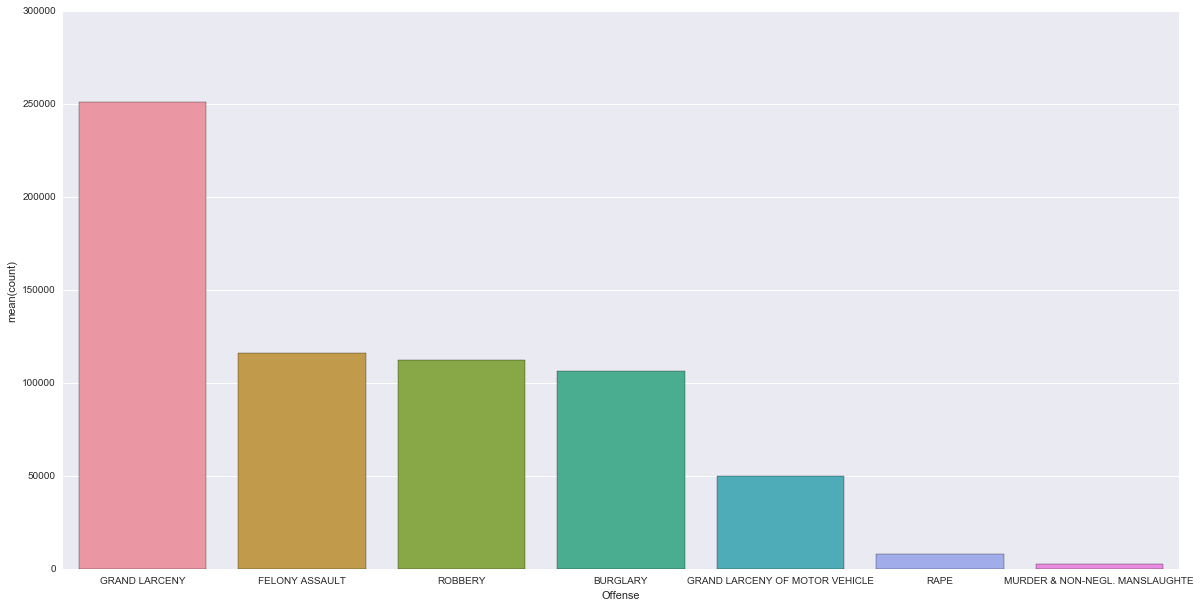

In [8]:
f, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=True)
sns.set_style("whitegrid")
ax = sns.barplot(x="Offense", y="count", data=result)
#counts of crimes

In [9]:
hourcount = df[['Occurrence Hour', 'count']]
hourgrouped = hourcount.groupby(['Occurrence Hour']).sum()

In [10]:
hourgrouped['Occurrence Hour']=hourgrouped.index

In [11]:
result = hourgrouped.sort(['Occurrence Hour'], ascending = True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


## look at what times of day the most and least crimes occur

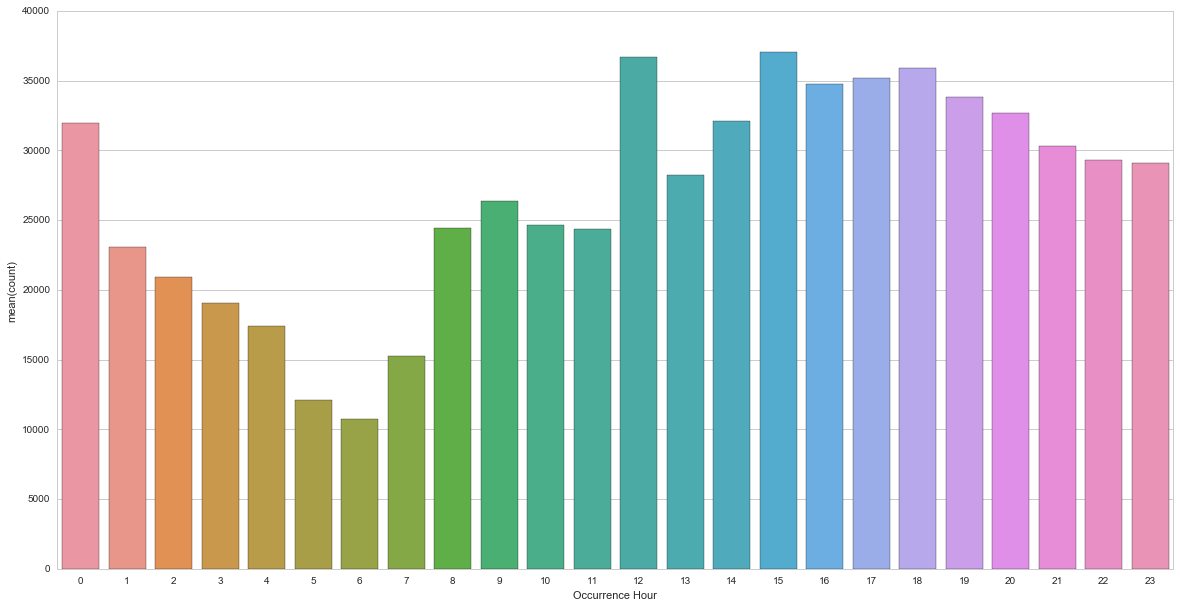

In [12]:
f, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=True)
sns.set_style("whitegrid")
ax = sns.barplot(x="Occurrence Hour", y="count", data=result)
#6am has the lowest crime rate while 3pm seems to have the highest

In [13]:
daycount = df[['Day of Week', 'count']]
daygrouped = daycount.groupby(['Day of Week']).sum()
daygrouped['Day of Week']=daygrouped.index
result = daygrouped.sort(['count'], ascending = False)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## look at counts of crimes by day of the week

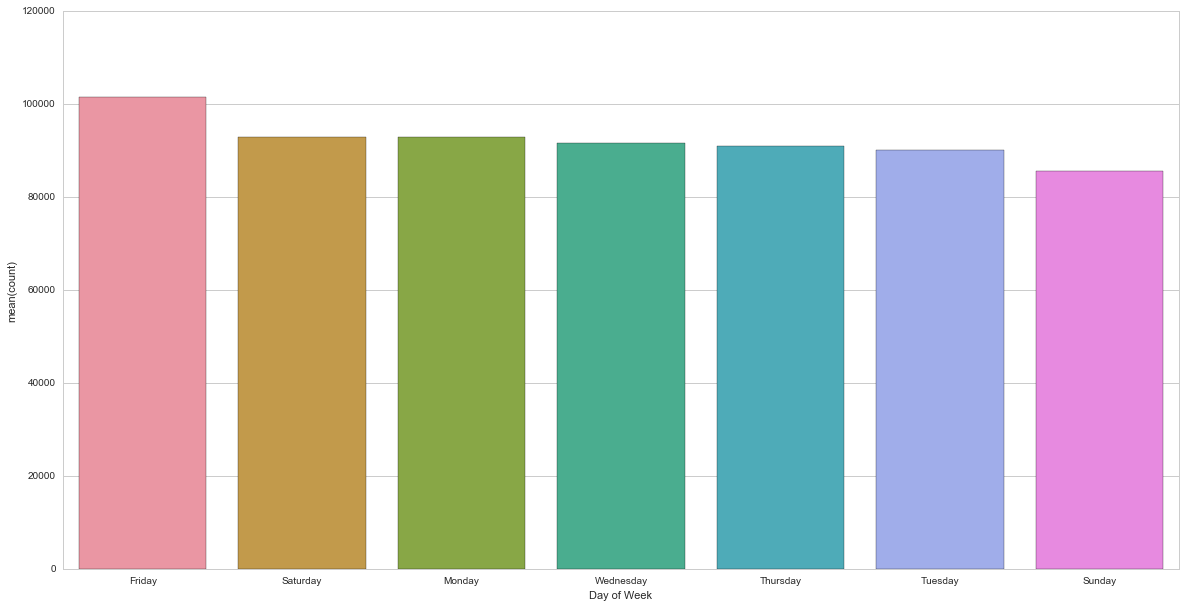

In [14]:
f, ax = plt.subplots(1, 1, figsize=(20, 10), sharex=True)
sns.set_style("whitegrid")
ax = sns.barplot(x="Day of Week", y="count", data=result)
#fridays have most reported crimes and sundays the least

In [15]:
#hour grouped
daycount = df[['Day of Week', 'count']]
daygrouped = daycount.groupby(['Day of Week']).sum()

In [16]:
#look at all crime reports over time 
df['Occurrence Date']=pd.to_datetime(df['Occurrence Date'])

In [ ]:
df.head()

In [17]:
dateandcount = df[['Occurrence Date', 'count']]
dateandcount.columns=[['date', 'count']]
dateandcount.index =dateandcount.date

In [18]:
dateandcount.head()
dateancount = dateandcount.drop('date', 1)

## look at counts of crimes grouped by day of week over time. seems to be some seasonality to the data

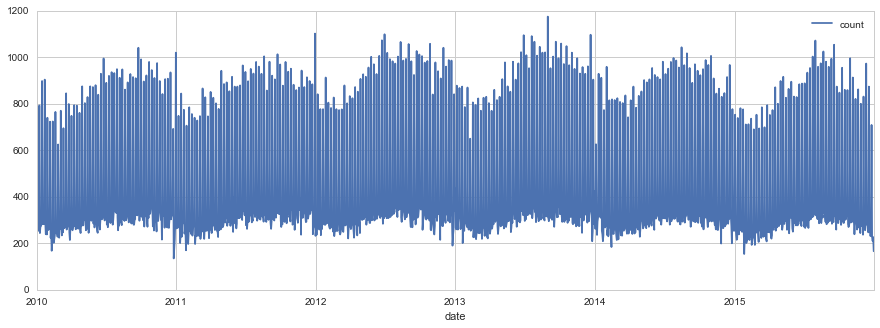

In [19]:
(dateandcount.resample('B',how='sum')).plot(figsize=(15, 5)) #crimes appear to be somewhat seasonal

## counts of crimes grouped by month across the years

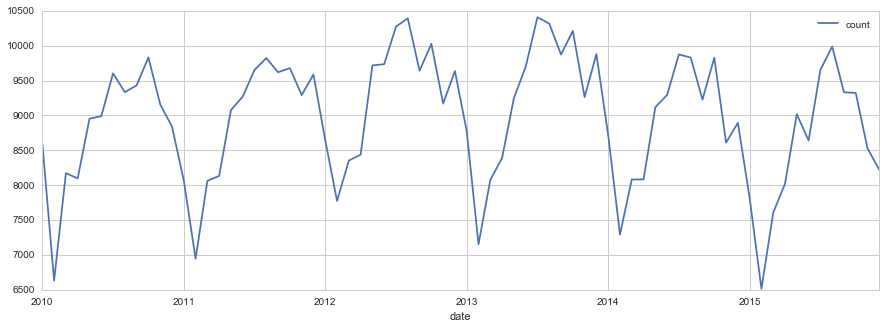

In [20]:
(dateandcount.resample('M',how='sum')).plot(figsize=(15, 5)) #crimes appear to be somewhat seasonal

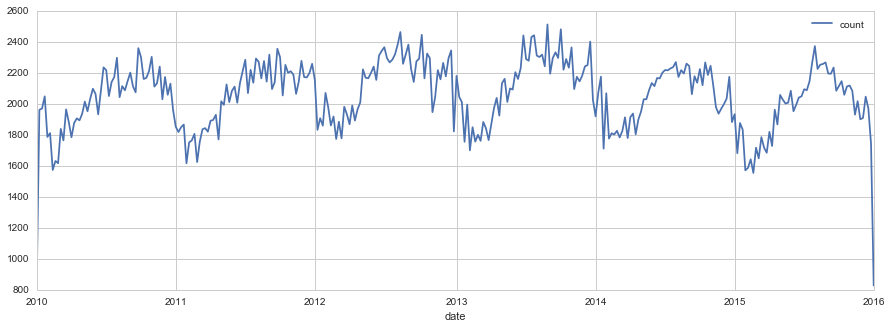

In [21]:
(dateandcount.resample('W',how='sum')).plot(figsize=(15, 5)) #crimes appear to be somewhat seasonal

## look at spread of crimes across NYC, Xcoordinate and Ycoordinate are comparable to latitude and longitude. Latitude and longitudes are in tuples want to convert them to two columns of a dataframe. 

In [26]:
dfxy=df[['XCoordinate', 'YCoordinate']]

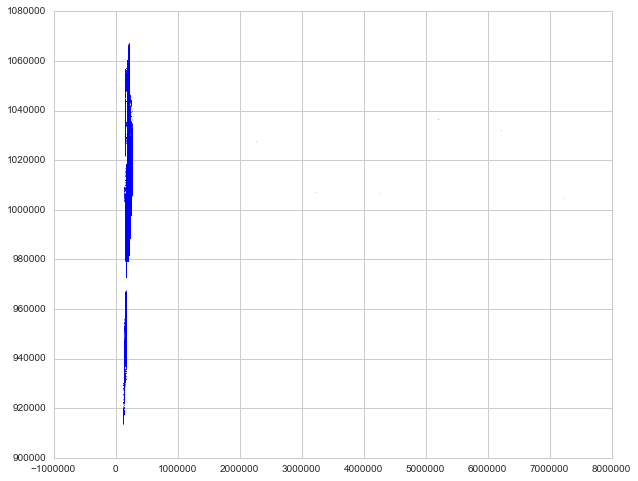

In [27]:
X = df['XCoordinate']
Y = df['YCoordinate']
fig = plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(Y,X,color='b',alpha=0.2, s=0.5)
plt.figure(figsize=(10, 8))
fig1 = plt.gcf()
plt.show()

## the data is not clean, there are locations outside of NYC so have to do some data cleaning and re-formatting.

In [11]:
dflocation = df['Location 1']

In [12]:
df['Location 1'][0]

'(40.8043840460001, -73.9374216689999)'

In [13]:
from ast import literal_eval as make_tuple
make_tuple(df['Location 1'][0])[0]

40.8043840460001

In [14]:
latitude = []
longitude = []
for i in dflocation:
    latitude.append(make_tuple(i)[0])
    longitude.append(make_tuple(i)[1])

In [15]:
dflat = pd.DataFrame(longitude, latitude)

In [16]:
dflat['latitude']=dflat.index

In [17]:
dflat.columns=[['longitude', 'latitude']]

In [18]:
dflat =dflat.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')



In [19]:
dflat.columns=[['latitude', 'longitude', 'weird']]

In [20]:
del dflat['weird']

In [21]:

result = pd.concat([newdf, dflat], axis=1, join='inner')
result.columns =[['objectid', 'identifier', 'occurrence_date', 'weekday','month', 'day', 'year','hour','compstatmonth','compstatday','compstatyear','offense','offenseclassification','sector','precinct','borough','jurisdiction','xcoord','ycoord','latitude','longitude']]

In [22]:
result.head()

,objectid,identifier,occurrence_date,weekday,month,day,year,hour,compstatmonth,compstatday,compstatyear,offense,offenseclassification,sector,precinct,borough,jurisdiction,xcoord,ycoord,latitude,longitude
0,5440,aae098f0,10/02/2015 12:11:00 PM,Monday,Oct,2,2015,12,11,23,2015,GRAND LARCENY,FELONY,B,25,MANHATTAN,N.Y. POLICE DEPT,1001575,232339,40.804384,-73.937422
1,17512,d71bac4b,09/06/2015 02:00:00 AM,Wednesday,Sep,6,2015,2,10,2,2015,FELONY ASSAULT,FELONY,G,90,BROOKLYN,N.Y. HOUSING POLICE,999983,195658,40.703707,-73.943258
2,17589,ea9926ff,12/10/2015 04:45:00 PM,Sunday,Dec,10,2015,16,12,10,2015,FELONY ASSAULT,FELONY,C,18,MANHATTAN,N.Y. POLICE DEPT,991707,216641,40.761311,-73.973083
3,17626,ae713901,12/01/2015 02:30:00 PM,Friday,Dec,1,2015,14,12,1,2015,GRAND LARCENY,FELONY,H,94,BROOKLYN,N.Y. POLICE DEPT,994636,200707,40.717573,-73.962535
4,328895,f5b51b25,01/05/2010 12:00:00 AM,Tuesday,Jan,5,2010,0,1,7,2010,GRAND LARCENY,FELONY,F,76,BROOKLYN,N.Y. POLICE DEPT,984387,185153,40.674887,-73.999508


In [48]:
con = mdb.connect('localhost', 'root', '', 'crimedata') 
db = result.to_sql('crimedatatable', con, flavor='mysql')

In [55]:
locfilt = pd.read_sql('SELECT offense, xcoord, ycoord, latitude, longitude  FROM crimedatatable WHERE (latitude BETWEEN 40.498294 AND 40.915087) AND (longitude BETWEEN -74.257061 AND -73.699273)', con)

In [50]:
len(locfilt)

645432

In [84]:
latlong = locfilt[['longitude', 'latitude']]

In [89]:
latlonga = latlong.values

In [92]:
import sklearn.datasets as datasets

In [95]:
datasets

<module 'sklearn.datasets' from '/Users/cedarwaxwing/Library/Python/2.7/lib/python/site-packages/sklearn/datasets/__init__.pyc'>

In [ ]:
plt.jet()

In [97]:
from sklearn.cross_validation import train_test_split
x = locfilt['longitude']
y = locfilt['latitude']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [120]:
x=x.reshape(645432,1)
y=y.reshape(645432,1)

In [104]:
from sklearn.cluster import KMeans
kmeans = KMeans(100, random_state=8)
Y_hat = kmeans.fit(x).labels_

## can now look at scatter plot of individual crime reports

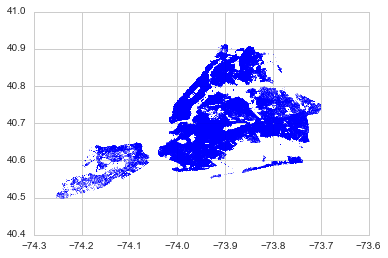

In [83]:
x = locfilt['longitude']
y = locfilt['latitude']
#fig = plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(x,y,color='b',alpha=0.2, s=0.5)
#plt.figure(figsize=(10, 8))

#fig1 = plt.gcf()
plt.show()

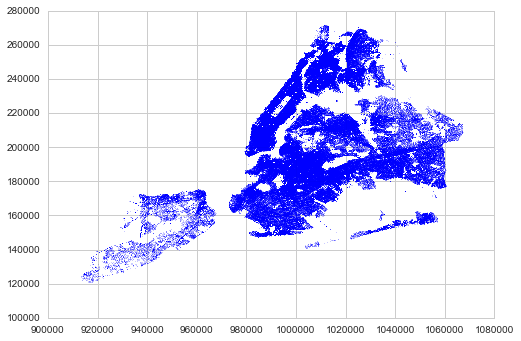

In [57]:
x = locfilt['xcoord']
y = locfilt['ycoord']
#fig = plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(x,y,color='b',alpha=0.2, s=0.5)
plt.figure(figsize=(10, 8))


fig1 = plt.gcf()
plt.show()

In [66]:
rapes = locfilt[locfilt.offense.str.contains("RAPE") == True] #remove all not guilties

In [70]:
murders = locfilt[locfilt.offense.str.contains("MURDER") == True] #remove all not guilties

## can look at crimes by description (rapes in blue, murders in red)

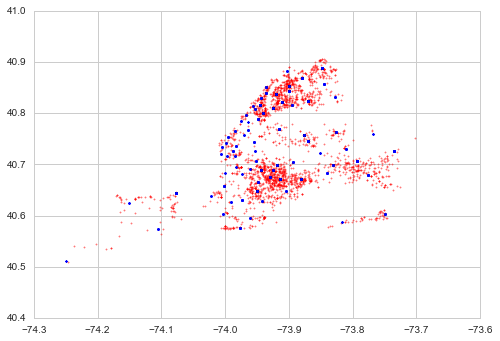

In [79]:
xr = rapes['longitude']
yr = rapes['latitude']
xm = murders['longitude']
ym = murders['latitude']
#fig = plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(xm,ym,color='r',alpha=0.5, s=2)
plt.scatter(xr,yr,color='b', alpha=0.5, s=2)

plt.figure(figsize=(10, 8))


fig1 = plt.gcf()
plt.show()

## look at crime clustering based on number of police precincts, do the cluster centers match up with designated precinct centers?

In [108]:
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [109]:
X_digits, _,_, Y_digits = fetch_mldata("MNIST Original").values()

In [115]:
X_digits.shape

(70000, 784)

In [116]:
X_digits = X_digits[-5000:]  

In [118]:
X_digits.shape

(5000, 784)

In [119]:
kmeans = KMeans(20)
mu_digits = kmeans.fit(X_digits).cluster_centers_

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten


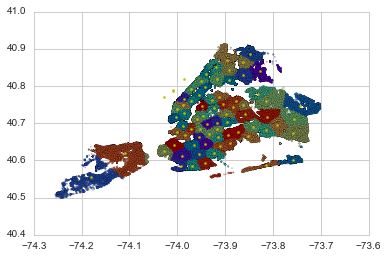

In [157]:

#arr = np.random.randn(500000*3).reshape((500000, 3))
x, y = kmeans2(latlonga, 76, iter = 20)  #<--- I randomly picked 7 clusters
plt.scatter(latlonga[:,0], latlonga[:,1],c=y,cmap='rainbow', alpha=0.33333, s=2)
plt.scatter(x[:,0],x[:,1], color= 'y', s=5)

## cluster centers

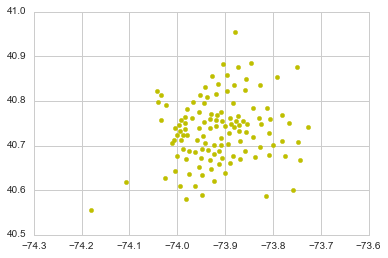

In [153]:
plt.scatter(x[:,0],x[:,1], color = 'y')
plt.scatter()

## load in precinct data

In [23]:
precincts = pd.read_csv('nypdprecincts.csv')

In [24]:
precincts = precincts[['Unnamed: 0', 'Unnamed: 1','Unnamed: 2']]

In [25]:
precincts.columns=[['precinct','phonenum','street']]

In [26]:
precincts = precincts[precincts.street.notnull()]

In [27]:
precincts.head()

,precinct,phonenum,street
0,1st Precinct,(212) 334-0611,16 Ericsson Place
1,5th Precinct,(212) 334-0711,19 Elizabeth Street
2,6th Precinct,(212) 741-4811,233 West 10 Street
3,7th Precinct,(212) 477-7311,19 1/2 Pitt Street
4,9th Precinct,(212) 477-7811,321 East 5 Street


## doing some data cleaning, need to convert precinct addresses to lat and lon coordinates

In [185]:
address=precincts['street'].values.tolist()

In [186]:
address

['16 Ericsson Place',
 '19 Elizabeth Street',
 '233 West 10 Street',
 '19 1/2 Pitt Street',
 '321 East 5 Street',
 '230 West 20th Street',
 '230 East 21st Street',
 '357 West 35th Street\xc2\xa0',
 '167 East 51st Street',
 '306 West 54th Street',
 '153 East 67th Street',
 '120 West 82nd Street',
 '86th St & Transverse Road\xc2\xa0',
 '162 East 102nd Street',
 '151 West 100th Street',
 '120 East 119th Street',
 '520 West 126th Street',
 '2271-89 8th Avenue',
 '451 West 151st Street',
 '250 West 135th Street',
 '2207 Amsterdam Avenue',
 '4295 Broadway',
 '257 Alexander Avenue',
 '1035 Longwood Avenue',
 '830 Washington Avenue',
 '900 Fteley Avenue',
 '2 East 169th Street',
 '2877 Barkley Avenue',
 '2120 Ryer Avenue',
 '4111 Laconia Avenue',
 '450 Cross Bronx Expressway',
 '2121 Eastchester Road',
 '3450 Kingsbridge Avenue',
 '3016 Webster Avenue',
 '2951 West 8th Street',
 '2575 Coney Island Avenue',
 '1925 Bath Avenue',
 '1844 Brooklyn Avenue',
 '5822 16th Avenue',
 '2820 Snyder Avenue'

In [167]:
def addresstolatlon(str(address)):
    try:
        g = geocoder.google(address + ', New York')
        lon=g.geojson['geometry']['coordinates'][0]
        lat=g.geojson['geometry']['coordinates'][1]
        precinct.append(str(address))
    except:
        fail.append(str(address))

In [172]:
precinctlatlon=[]
fail=[]
for a in address:
    try:
        g = geocoder.google(str(address) + ', New York')
        lon=g.geojson['geometry']['coordinates'][0]
        lat=g.geojson['geometry']['coordinates'][1]
        precinctlatlon.append((lat,lon))
    except:
        fail.append(str(address))
    

In [177]:
addresses=precincts['street'].values.tolist()


In [179]:
addresses=addresses[0:10]

In [182]:
addresses=precincts['street'].values.tolist()
for i in addresses:
    try:
        g = geocoder.google(i + ', New York')
        lon=g.geojson['geometry']['coordinates'][0]
        lat=g.geojson['geometry']['coordinates'][1]
        precinctlatlon.append((lat,lon))
    except:
        fail.append(i)

In [187]:
precinctlatlondf = pd.DataFrame(precinctlatlon)
precinctlatlondf.columns=['latitude', 'longitude']

In [189]:
xlong=precinctlatlondf['longitude']
ylat=precinctlatlondf['latitude']

In [235]:
precinctlatlon
import pickle
pickle.dump( precinctlatlon, open( "precinctlatlon.p", "wb" ) )

## comparing precincts and cluster centers

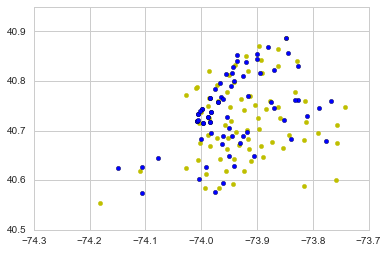

In [190]:
plt.scatter(x[:,0],x[:,1], color = 'y')
plt.scatter(xlong,ylat)

In [232]:
x= latlong['longitude']
y= latlong['latitude']

In [197]:
npoints = -1

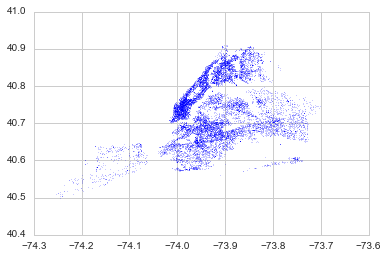

In [198]:
#fig = plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(x,y,color='b',alpha=0.2, s=0.5)
#plt.figure(figsize=(10, 8))

#fig1 = plt.gcf()
plt.show()

In [202]:
len(x)

17000

In [204]:
points = np.array(zip(x,y))

In [206]:
arr = points
X = points

## using another clustering method designed by Erik Nylen code from https://github.com/erikleenylen/dronebaseresearch

In [207]:

n_clusters = 76
init_type = 'k-means++'
k_means = KMeans(init=init_type, n_clusters=n_clusters, n_init=300)
#t0 = time.time()
k_means.fit(arr)
#t_batch = time.time() - t0
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

In [210]:
rescaled_k_means_cluster_centers=np.array([[_[0],_[1]] for _ in k_means_cluster_centers])
kmeansdfplus = pd.DataFrame(rescaled_k_means_cluster_centers,columns=['longitude','latitude'])

In [211]:
kmeansdfplus

,longitude,latitude
0,-73.914292,40.837106
1,-73.948385,40.635482
2,-73.802457,40.679647
3,-74.107208,40.574685
4,-73.985385,40.737249
5,-73.868250,40.752020
6,-73.860017,40.857338
7,-73.964592,40.682573
8,-73.928468,40.673070
9,-73.744746,40.701806


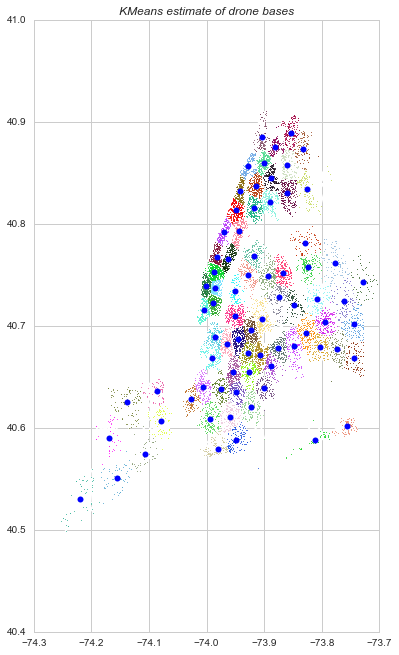

In [231]:

fig = plt.figure(figsize=(5,10))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
#colors = ['#4EACC5', '#FF9C34', '#4E9A06']
colors = [(np.random.rand(),np.random.rand(),np.random.rand()) for __ in range(n_clusters)]

ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',markerfacecolor=col, marker='.',markersize=2)
    ax.plot(cluster_center[0], cluster_center[1], 'o',markerfacecolor='b',markeredgecolor='k', markersize=6)
ax.set_title('KMeans estimate of clusters by number of precincts',style = 'italic')
